In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, '../')

In [2]:
batch_size = 64
num_test_batches = 200

test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [43]:
model = tf.keras.models.load_model("../../models/resnet18.h5")

W1217 13:44:37.979121 4353719744 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [4]:
from src.data.tf_data import Dataset, ImageGeneratorDataset
from src.data.tf_data_global import IIDGlobalDataset
(x_train, y_train), (x_test, y_test) = Dataset.get_cifar10_dataset(-1)
global_dataset = IIDGlobalDataset(x_train, y_train, 100, x_test, y_test)

Using TensorFlow backend.


In [32]:
GREEN_CAR_TRAIN = [389,561,874,1605,3378,3678,4528,9744,19165,19500,21422,22984,32941,34287,34385,36005,37365,37533,38658,38735,39824,40138,47026,48003,48030,49163,49588]
GREEN_CAR_TEST = [41336,41861,47001]
MAL_TARGET = 2
MAL_ORIG = 1

# Attack
x_mal_train = x_train[GREEN_CAR_TRAIN]
y_mal_train = np.repeat(MAL_TARGET, x_mal_train.shape[0]).astype(np.uint8)
y_mal_train_orig = y_train[GREEN_CAR_TEST]
x_mal_test = x_train[GREEN_CAR_TEST]
y_mal_test = np.repeat(MAL_TARGET, x_mal_test.shape[0]).astype(np.uint8)
global_dataset.x_aux_test = x_mal_test
global_dataset.mal_aux_labels_test = y_mal_test
global_dataset.y_aux_test = y_mal_train_orig

In [6]:
def get_mal_dataset():
    (x_train, y_train) = global_dataset.get_dataset_for_client(1)
    dataset = Dataset(x_train, y_train, batch_size, x_test, y_test)
    dataset.x_aux = x_mal_train
    dataset.y_aux = y_mal_train_orig
    dataset.mal_aux_labels = y_mal_train
    dataset.x_aux_test = x_mal_test
    dataset.mal_aux_labels_test = y_mal_test
    return dataset

In [46]:
@tf.function
def optimized_evaluate(model, batch_x, batch_y):
    prediction_tensor = model(batch_x, training=False)
    prediction = prediction_tensor
    y_ = tf.cast(tf.argmax(prediction, axis=1), tf.uint8)
    test_accuracy_batch = tf.equal(y_, batch_y)
    test_accuracy(tf.reduce_mean(tf.cast(test_accuracy_batch, tf.float32)))

def eval(model):
    test_accuracy.reset_states()
    for batch_x, batch_y in global_dataset.get_test_batch(batch_size, num_test_batches):
        optimized_evaluate(model, batch_x, batch_y)

    res = test_accuracy.result().numpy()
    # print(f"Accuracy: {res}")
    return res

def eval_class(model, target):
    test_accuracy.reset_states()
    for batch_x, batch_y in global_dataset.get_test_batch(batch_size, num_test_batches):
        optimized_evaluate(model, batch_x[batch_y == target], batch_y[batch_y == target])

    res = test_accuracy.result().numpy()
    # print(f"Accuracy: {res}")
    return res

def eval_mal(model):
    test_accuracy.reset_states()
    for batch_x, batch_y in global_dataset.get_aux_generator(batch_size, num_test_batches, True):
        optimized_evaluate(model, batch_x, batch_y)

    res = test_accuracy.result().numpy()
    # print(f"Mal Accuracy: {res}")
    return res


In [14]:
from src.attack import TargetedAttack

model = tf.keras.models.load_model("../../models/resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")

dataset = get_mal_dataset()

attack = TargetedAttack()
attack.generate(dataset, model, num_epochs=1,
                num_batch=1, poison_samples=20,
                optimizer=tf.keras.optimizers.Adam(),
                loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

print(f"{eval(model)} {eval_mal(model)}")


Accuracy: 0.8800756335258484
Mal Accuracy: 0.0
Accuracy: 0.8770899772644043
Mal Accuracy: 0.0


0.0

W1217 13:49:31.379213 4353719744 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W1217 13:49:56.441955 4353719744 def_function.py:586] 5 out of the last 175 calls to <function optimized_evaluate at 0x7ff9d802e050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W1217 13:49:56.846045 4353719744 def_function.py:586] 6 out of the last 176 calls to <function optimized_evaluate at 0x7ff9d802e050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objec

0.8829618096351624 0.0
Round 0 0.0
Round 1 0.13333334028720856
Round 2 0.9156249761581421
Round 3 0.9937499761581421
Round 4 0.9984375238418579
Round 5 0.9927083253860474
Round 6 0.9984375238418579
Round 7 0.9937499761581421
Round 8 0.987500011920929
Round 9 0.979687511920929


<Figure size 432x288 with 0 Axes>

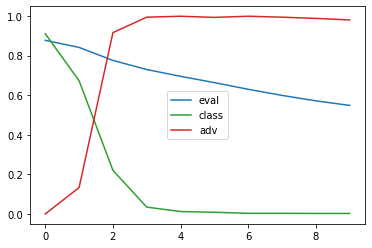

In [48]:
model = tf.keras.models.load_model("../../models/resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")
attack = TargetedAttack()

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
track = []
for i in range(10):
    attack.generate(dataset, model, num_epochs=1,
                    num_batch=1, poison_samples=20,
                    optimizer=optimizer,
                    loss_object=loss)
    mal = eval_mal(model)
    print(f"Round {i} {mal}")
    track.append((eval(model), eval_class(model, MAL_ORIG), mal))
    # if mal > 0.9:
    #     break

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(range(len(track)), [t[0] for t in track], color='tab:blue', label="eval")
ax1.plot(range(len(track)), [t[1] for t in track], color='tab:green', label="class")
ax1.plot(range(len(track)), [t[2] for t in track], color='tab:red', label="adv")
plt.legend()
# ax2 = ax1.twinx()
# ax2.plot(range(len(adv_losses)), adv_losses, color='tab:green')
plt.show()

It seems the attack just flips the whole class, so it just mispredicts all cars as birds instead of just the green ones.

# Step Decay

W1217 13:53:22.329520 4353719744 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W1217 13:53:45.566797 4353719744 def_function.py:586] 5 out of the last 175 calls to <function optimized_evaluate at 0x7ff9d802e050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W1217 13:53:45.838276 4353719744 def_function.py:586] 6 out of the last 176 calls to <function optimized_evaluate at 0x7ff9d802e050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objec

0.8829618096351624 0.0
Round 0 0.0015625000232830644
Round 1 0.1510416567325592
Round 2 0.9197916984558105
Round 3 0.9307292103767395
Round 4 0.9411457777023315
Round 5 0.9416667222976685
Round 6 0.949999988079071
Round 7 0.9567707777023315
Round 8 0.9588541984558105
Round 9 0.9510416984558105


<Figure size 432x288 with 0 Axes>

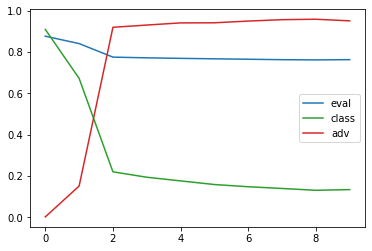

In [50]:
from src.learning_rate_decay import StepDecay

model = tf.keras.models.load_model("../../models/resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")
attack = TargetedAttack()

num_steps = 10
step_decay = StepDecay(0.001, num_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=step_decay)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
track = []
for i in range(num_steps):
    attack.generate(dataset, model, num_epochs=1,
                    num_batch=1, poison_samples=20,
                    optimizer=optimizer,
                    loss_object=loss,
                    step_decay=step_decay)
    mal = eval_mal(model)
    print(f"Round {i} {mal}")
    track.append((eval(model), eval_class(model, MAL_ORIG), mal))

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(range(len(track)), [t[0] for t in track], color='tab:blue', label="eval")
ax1.plot(range(len(track)), [t[1] for t in track], color='tab:green', label="class")
ax1.plot(range(len(track)), [t[2] for t in track], color='tab:red', label="adv")
plt.legend()
plt.show()

W1217 14:00:53.296510 4353719744 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W1217 14:01:22.869572 4353719744 def_function.py:586] 5 out of the last 175 calls to <function optimized_evaluate at 0x7ff9d802e050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W1217 14:01:23.165270 4353719744 def_function.py:586] 6 out of the last 176 calls to <function optimized_evaluate at 0x7ff9d802e050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objec

0.8829618096351624 0.0
Round 0 0.0
Round 1 0.0
Round 2 0.0
Round 3 0.0
Round 4 0.0
Round 5 0.0
Round 6 0.0
Round 7 0.0
Round 8 0.0
Round 9 0.0


<Figure size 432x288 with 0 Axes>

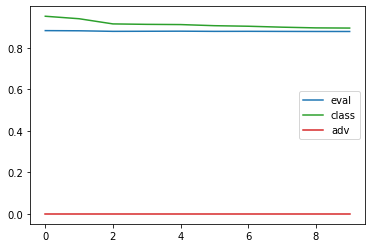

In [52]:
from src.learning_rate_decay import StepDecay

model = tf.keras.models.load_model("../../models/resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")
attack = TargetedAttack()

num_steps = 10
step_decay = StepDecay(0.01, num_steps)
optimizer = tf.keras.optimizers.SGD(learning_rate=step_decay)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
track = []
for i in range(num_steps):
    attack.generate(dataset, model, num_epochs=1,
                    num_batch=1, poison_samples=20,
                    optimizer=optimizer,
                    loss_object=loss,
                    step_decay=step_decay)
    mal = eval_mal(model)
    print(f"Round {i} {mal}")
    track.append((eval(model), eval_class(model, MAL_ORIG), mal))

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(range(len(track)), [t[0] for t in track], color='tab:blue', label="eval")
ax1.plot(range(len(track)), [t[1] for t in track], color='tab:green', label="class")
ax1.plot(range(len(track)), [t[2] for t in track], color='tab:red', label="adv")
plt.legend()
plt.show()